# Anomalies in Spark

In [1]:
sc

## BABS data

We'll use the data set found at http://www.bayareabikeshare.com/open-data.

In [1]:
raw_data = sc.textFile('data/201508_trip_data.csv.gz')

In [4]:
raw_data.take(5)

[u'Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code',
 u'913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139',
 u'913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032',
 u'913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107',
 u'913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113']

### Let's make a data frame out of the raw data.

In [21]:
from pyspark.sql import Row

In [88]:
durations = spark.createDataFrame(
    raw_data
    .filter(lambda x: not x.startswith('Trip'))
    .map(lambda x: x.split(','))
    .map(lambda x: Row(duration=int(x[1])))
)

In [89]:
durations.show(5)

+--------+
|duration|
+--------+
|     765|
|    1036|
|     307|
|     409|
|     789|
+--------+
only showing top 5 rows



In [90]:
import pyspark.sql.functions as fns
from pyspark.sql.types import FloatType

In [91]:
# calculate mean and stadard deviation
# NOTE: Median and median (absolute) deviation
#       from median are a better choice here.
stats = durations.select(fns.stddev(durations.duration).alias('sd'),
                         fns.mean(durations.duration).alias('mu')).collect()

In [15]:
stats

[Row(sd=30016.9361569297, mu=1046.0326611172604)]

In [16]:
mu, sd = stats[0].mu, stats[0].sd

In [20]:
# user defined function (udf) to calculate z values
make_z = fns.udf(lambda x: (x - mu) / sd, FloatType())

In [19]:
durations.select((durations.duration / 60).alias('duration_mins')).show(5)

+------------------+
|     duration_mins|
+------------------+
|             12.75|
|17.266666666666666|
| 5.116666666666666|
| 6.816666666666666|
|             13.15|
+------------------+
only showing top 5 rows



In [21]:
z_vals = durations.select(make_z(durations.duration).alias('z'))

In [22]:
z_vals.show(5)

+-------------+
|            z|
+-------------+
|  -0.00936247|
|-3.3423334E-4|
| -0.024620524|
|  -0.02122244|
| -0.008562922|
+-------------+
only showing top 5 rows



### Making a plot

In [24]:
zf = z_vals.toPandas()

In [27]:
%matplotlib inline

In [28]:
import matplotlib.pyplot as plt

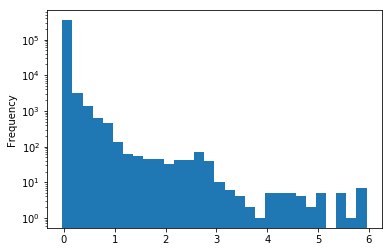

In [31]:
zf[zf.z < 6].z.plot.hist(bins=30)
plt.yscale('log')

## Clustering

Now we want to create a RDD of pairs `(date, vec)` where `vec[h]` contains the number of bike trips started at hour `h` on the day `date`.

In [2]:
dates = (raw_data
        .map(lambda x: x.split(','))
        .map(lambda x: x[2]))

In [3]:
dates.take(5)

[u'Start Date',
 u'8/31/2015 23:26',
 u'8/31/2015 23:11',
 u'8/31/2015 23:13',
 u'8/31/2015 23:10']

### Convert to datetime

In [4]:
from datetime import datetime, timedelta

In [5]:
def convert(date_string):
    try:
        return datetime.strptime(date_string, '%m/%d/%Y %H:%M')
    except ValueError:
        return None

In [7]:
dates = (dates
        .map(convert)
        .filter(lambda x: x != None))

In [9]:
dates.take(5)

[datetime.datetime(2015, 8, 31, 23, 26),
 datetime.datetime(2015, 8, 31, 23, 11),
 datetime.datetime(2015, 8, 31, 23, 13),
 datetime.datetime(2015, 8, 31, 23, 10),
 datetime.datetime(2015, 8, 31, 23, 9)]

In [10]:
from operator import add

### Make dictionaries with counts

In [11]:
def seqOp(d, (h, c)):
    d[h] = c
    return d
def combOp(d1, d2):
    d1.update(d2)
    return d1

In [14]:
counts = (dates
          .map(lambda x: ((x.year, x.month, x.day, x.hour), 1))
          .reduceByKey(add)
          .map(lambda ((y, m, d, h), c): ((y, m, d), (h, c)))
          .aggregateByKey({}, seqOp, combOp))

In [15]:
counts.take(5)

[((2014, 10, 25),
  {0: 4,
   1: 4,
   2: 5,
   3: 1,
   4: 1,
   7: 4,
   8: 12,
   9: 18,
   10: 30,
   11: 28,
   12: 44,
   13: 43,
   14: 37,
   15: 43,
   16: 27,
   17: 16,
   18: 29,
   19: 10,
   20: 9,
   21: 13,
   22: 15,
   23: 13}),
 ((2015, 1, 22),
  {0: 1,
   1: 1,
   4: 3,
   5: 8,
   6: 32,
   7: 99,
   8: 189,
   9: 133,
   10: 47,
   11: 40,
   12: 45,
   13: 36,
   14: 33,
   15: 57,
   16: 105,
   17: 176,
   18: 106,
   19: 54,
   20: 28,
   21: 13,
   22: 14,
   23: 4}),
 ((2015, 6, 14),
  {0: 2,
   1: 5,
   2: 2,
   3: 3,
   6: 3,
   7: 4,
   8: 6,
   9: 7,
   10: 13,
   11: 21,
   12: 22,
   13: 25,
   14: 22,
   15: 35,
   16: 30,
   17: 15,
   18: 13,
   19: 22,
   20: 6,
   21: 8,
   22: 3,
   23: 2}),
 ((2014, 12, 5),
  {0: 2,
   1: 1,
   2: 1,
   4: 1,
   5: 4,
   6: 31,
   7: 69,
   8: 166,
   9: 111,
   10: 54,
   11: 38,
   12: 45,
   13: 31,
   14: 25,
   15: 41,
   16: 82,
   17: 113,
   18: 90,
   19: 34,
   20: 13,
   21: 13,
   22: 8,
   23: 7}),


### Make the vectors

In [16]:
from pyspark.ml.linalg import Vectors

In [17]:
X = (counts
     .map(lambda (day, d): (day, Vectors.dense([d.get(i, 0) for i in range(24)]))))

In [18]:
X.cache()

PythonRDD[18] at RDD at PythonRDD.scala:48

In [19]:
X.take(5)

[((2014, 10, 25),
  DenseVector([4.0, 4.0, 5.0, 1.0, 1.0, 0.0, 0.0, 4.0, 12.0, 18.0, 30.0, 28.0, 44.0, 43.0, 37.0, 43.0, 27.0, 16.0, 29.0, 10.0, 9.0, 13.0, 15.0, 13.0])),
 ((2015, 1, 22),
  DenseVector([1.0, 1.0, 0.0, 0.0, 3.0, 8.0, 32.0, 99.0, 189.0, 133.0, 47.0, 40.0, 45.0, 36.0, 33.0, 57.0, 105.0, 176.0, 106.0, 54.0, 28.0, 13.0, 14.0, 4.0])),
 ((2015, 6, 14),
  DenseVector([2.0, 5.0, 2.0, 3.0, 0.0, 0.0, 3.0, 4.0, 6.0, 7.0, 13.0, 21.0, 22.0, 25.0, 22.0, 35.0, 30.0, 15.0, 13.0, 22.0, 6.0, 8.0, 3.0, 2.0])),
 ((2014, 12, 5),
  DenseVector([2.0, 1.0, 1.0, 0.0, 1.0, 4.0, 31.0, 69.0, 166.0, 111.0, 54.0, 38.0, 45.0, 31.0, 25.0, 41.0, 82.0, 113.0, 90.0, 34.0, 13.0, 13.0, 8.0, 7.0])),
 ((2014, 11, 6),
  DenseVector([2.0, 0.0, 2.0, 0.0, 5.0, 7.0, 29.0, 103.0, 235.0, 135.0, 69.0, 56.0, 71.0, 57.0, 39.0, 56.0, 123.0, 178.0, 121.0, 41.0, 33.0, 29.0, 13.0, 6.0]))]

In [22]:
Xdf = spark.createDataFrame(
    X.map(lambda (day, v): Row(day=day, features=v))
)

In [23]:
Xdf.show(5)

+------------+--------------------+
|         day|            features|
+------------+--------------------+
|[2014,10,25]|[4.0,4.0,5.0,1.0,...|
| [2015,1,22]|[1.0,1.0,0.0,0.0,...|
| [2015,6,14]|[2.0,5.0,2.0,3.0,...|
| [2014,12,5]|[2.0,1.0,1.0,0.0,...|
| [2014,11,6]|[2.0,0.0,2.0,0.0,...|
+------------+--------------------+
only showing top 5 rows



In [24]:
from pyspark.ml.clustering import KMeans

In [25]:
Xdf.cache()

DataFrame[day: struct<_1:bigint,_2:bigint,_3:bigint>, features: vector]

## Elbow Method

In [26]:
ks = range(2, 10)
costs = []
for k in ks:
    model = KMeans().setK(k).fit(Xdf)
    costs.append(model.computeCost(Xdf))

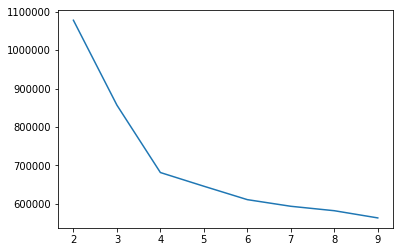

In [29]:
plt.plot(ks, costs)

In [30]:
model = KMeans().setK(4).fit(Xdf)

In [31]:
predictions = model.transform(Xdf)

In [43]:
predictions.show(5)

+------------+--------------------+----------+
|         day|            features|prediction|
+------------+--------------------+----------+
|[2014,10,25]|[4.0,4.0,5.0,1.0,...|         1|
| [2015,1,22]|[1.0,1.0,0.0,0.0,...|         2|
| [2015,6,14]|[2.0,5.0,2.0,3.0,...|         1|
| [2014,12,5]|[2.0,1.0,1.0,0.0,...|         2|
| [2014,11,6]|[2.0,0.0,2.0,0.0,...|         0|
+------------+--------------------+----------+
only showing top 5 rows



### Visualize cluster centers

These will display the typical per-hour counts for each cluster.

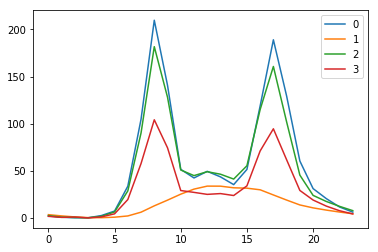

In [92]:
for i, center in enumerate(model.clusterCenters()):
    plt.plot(center, label=str(i))
plt.legend()

## Cluster Quality

We'll now investigate which days and months end up typically in our clusters to judge how well our clustering did.

In [36]:
from calendar import day_abbr, month_abbr

In [37]:
from datetime import date

In [38]:
def get_weekday(d):
    return day_abbr[date(*d).weekday()]

In [39]:
from pyspark.sql.types import StringType

In [46]:
weekday = fns.udf(get_weekday, StringType())

In [47]:
per_weekday = predictions.select(weekday(predictions.day).alias('weekday'),
                                 predictions.prediction.alias('class'))

In [49]:
per_weekday.show(5)

+-------+-----+
|weekday|class|
+-------+-----+
|    Sat|    1|
|    Thu|    2|
|    Sun|    1|
|    Fri|    2|
|    Thu|    0|
+-------+-----+
only showing top 5 rows



### Visualize

In [52]:
day_df = per_weekday.groupBy('class', 'weekday').count().toPandas()

In [53]:
day_df.head()

,class,weekday,count
0,1,Thu,4
1,0,Wed,39
2,2,Thu,15
3,2,Tue,6
4,2,Mon,7


In [82]:
[day_abbr[i] for i in range(7)]

['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

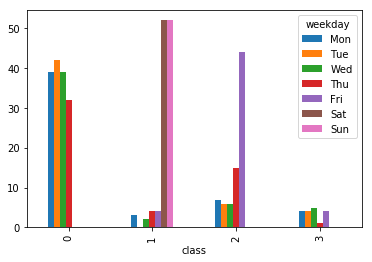

In [83]:
day_df.pivot_table(columns='weekday', values='count', index='class')[[day_abbr[i] for i in range(7)]].plot.bar()

In [57]:
per_month = predictions.select(fns.udf(lambda x: month_abbr[x[1]],
                                   StringType())(predictions.day).alias('month'),
                              predictions.prediction.alias('class'))

In [58]:
mdf = per_month.groupBy('month', 'class').count().toPandas()

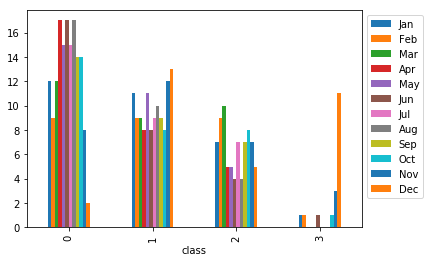

In [86]:
mdf.pivot_table(columns='month', index='class', values='count')[[month_abbr[i] for i in range(1, 13)]].plot.bar()
plt.legend(bbox_to_anchor=(1,1))

## Anomalies

We now inspect the distances of each point from the cluster centers to identify anomalous days.

In [62]:
centers = model.clusterCenters()
def dist_from_center(x, cluster):
    return float((x - centers[cluster]).norm(2))

In [66]:
d_udf = fns.udf(dist_from_center, FloatType())

In [67]:
dists = predictions.select(d_udf(predictions['features'],
                                 predictions['prediction']).alias('dist'),
                          predictions['day'],
                          predictions['prediction'].alias('cluster'))

In [68]:
dists.show(5)

+---------+------------+-------+
|     dist|         day|cluster|
+---------+------------+-------+
|27.534004|[2014,10,25]|      1|
|29.889078| [2015,1,22]|      2|
|32.172504| [2015,6,14]|      1|
|   74.816| [2014,12,5]|      2|
| 50.23313| [2014,11,6]|      0|
+---------+------------+-------+
only showing top 5 rows



### Collect Stats

We'll collect the mean and standard deviation per cluster to compute $z$ values.

In [69]:
dist_stats = dists.groupBy('cluster').agg(fns.stddev_pop('dist').alias('sd'),
                                         fns.mean('dist').alias('mu'))

In [70]:
dist_stats.show()

+-------+------------------+------------------+
|cluster|                sd|                mu|
+-------+------------------+------------------+
|      1|12.128219273447947|33.481062587509804|
|      3| 17.12081747981629| 75.04030460781522|
|      2|12.379594133162225| 45.19279406620906|
|      0| 9.380011877670958| 39.86197157909996|
+-------+------------------+------------------+



In [73]:
joined = dists.join(dist_stats, dist_stats.cluster == dists.cluster).drop(dists.cluster)

In [74]:
joined.show(5)

+---------+------------+-------+------------------+------------------+
|     dist|         day|cluster|                sd|                mu|
+---------+------------+-------+------------------+------------------+
|27.534004|[2014,10,25]|      1|12.128219273447947|33.481062587509804|
|29.889078| [2015,1,22]|      2|12.379594133162225| 45.19279406620906|
|32.172504| [2015,6,14]|      1|12.128219273447947|33.481062587509804|
|   74.816| [2014,12,5]|      2|12.379594133162225| 45.19279406620906|
| 50.23313| [2014,11,6]|      0| 9.380011877670958| 39.86197157909996|
+---------+------------+-------+------------------+------------------+
only showing top 5 rows



In [76]:
# calculate z-values
z_vals = joined.select(fns.udf(lambda d, mu, sd: (d - mu) / sd, FloatType())(
    joined.dist, joined.mu, joined.sd).alias('z'), joined.day, joined.cluster)

In [77]:
z_vals.show(5)

+------------+------------+-------+
|           z|         day|cluster|
+------------+------------+-------+
| -0.49034885|[2014,10,25]|      1|
|   -1.236205| [2015,1,22]|      2|
|-0.107893676| [2015,6,14]|      1|
|   2.3929062| [2014,12,5]|      2|
|   1.1056659| [2014,11,6]|      0|
+------------+------------+-------+
only showing top 5 rows



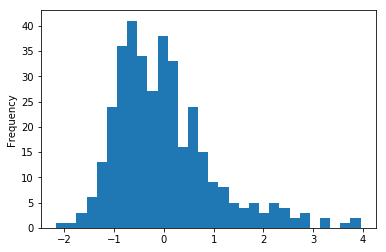

In [79]:
# visualize z-values
# Note we don't get any outliers with z > 4
z_vals.toPandas().z.plot.hist(bins=30)

In [80]:
# Show the 5 most anomalous days.
z_vals.orderBy(z_vals.z.desc()).show(5)

+---------+------------+-------+
|        z|         day|cluster|
+---------+------------+-------+
|3.9503138|  [2015,6,1]|      0|
|3.9228203|[2014,10,20]|      0|
|3.5701468|[2014,12,11]|      1|
|3.2589567|  [2015,3,9]|      2|
|3.1451936| [2014,9,25]|      2|
+---------+------------+-------+
only showing top 5 rows

